In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import root_mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import periodogram
import itertools
import time
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna

c:\Users\ivan.trujillo_blueta\proyectos\personal\bike_sharing_demand\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
train["datetime"].min(), train["datetime"].max()

('2011-01-01 00:00:00', '2012-12-19 23:00:00')

In [6]:
train[train["datetime"].str.contains("2011-01-01")]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [7]:
train[train["datetime"].str.contains("2011-01")]["datetime"]

0      2011-01-01 00:00:00
1      2011-01-01 01:00:00
2      2011-01-01 02:00:00
3      2011-01-01 03:00:00
4      2011-01-01 04:00:00
              ...         
426    2011-01-19 19:00:00
427    2011-01-19 20:00:00
428    2011-01-19 21:00:00
429    2011-01-19 22:00:00
430    2011-01-19 23:00:00
Name: datetime, Length: 431, dtype: object

In [8]:
test["datetime"].min(), test["datetime"].max()

('2011-01-20 00:00:00', '2012-12-31 23:00:00')

In [9]:
test[test["datetime"].str.contains("2011-01")]["datetime"]

0      2011-01-20 00:00:00
1      2011-01-20 01:00:00
2      2011-01-20 02:00:00
3      2011-01-20 03:00:00
4      2011-01-20 04:00:00
              ...         
252    2011-01-31 19:00:00
253    2011-01-31 20:00:00
254    2011-01-31 21:00:00
255    2011-01-31 22:00:00
256    2011-01-31 23:00:00
Name: datetime, Length: 257, dtype: object

In [10]:
train["holiday"].value_counts()

holiday
0    10575
1      311
Name: count, dtype: int64

In [11]:
train["workingday"].value_counts()

workingday
1    7412
0    3474
Name: count, dtype: int64

In [12]:
train = pd.get_dummies(train, columns=["season", "weather"], drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=["season", "weather"], drop_first=True, dtype=int)

In [13]:
train = train.drop(["casual", "registered"], axis=1)

In [14]:
train.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_2,season_3,season_4,weather_2,weather_3,weather_4
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.23086,23.655084,61.886460,12.799395,191.574132,0.251056,0.251056,0.251148,0.260334,0.078909,0.000092
std,0.166599,0.466159,7.79159,8.474601,19.245033,8.164537,181.144454,0.433641,0.433641,0.433694,0.438837,0.269609,0.009584
min,0.000000,0.000000,0.82000,0.760000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.94000,16.665000,47.000000,7.001500,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,26.24000,31.060000,77.000000,16.997900,284.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,41.00000,45.455000,100.000000,56.996900,977.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
train.isna().sum()

datetime      0
holiday       0
workingday    0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
season_2      0
season_3      0
season_4      0
weather_2     0
weather_3     0
weather_4     0
dtype: int64

<Axes: title={'center': 'Bike Rentals'}, xlabel='datetime'>

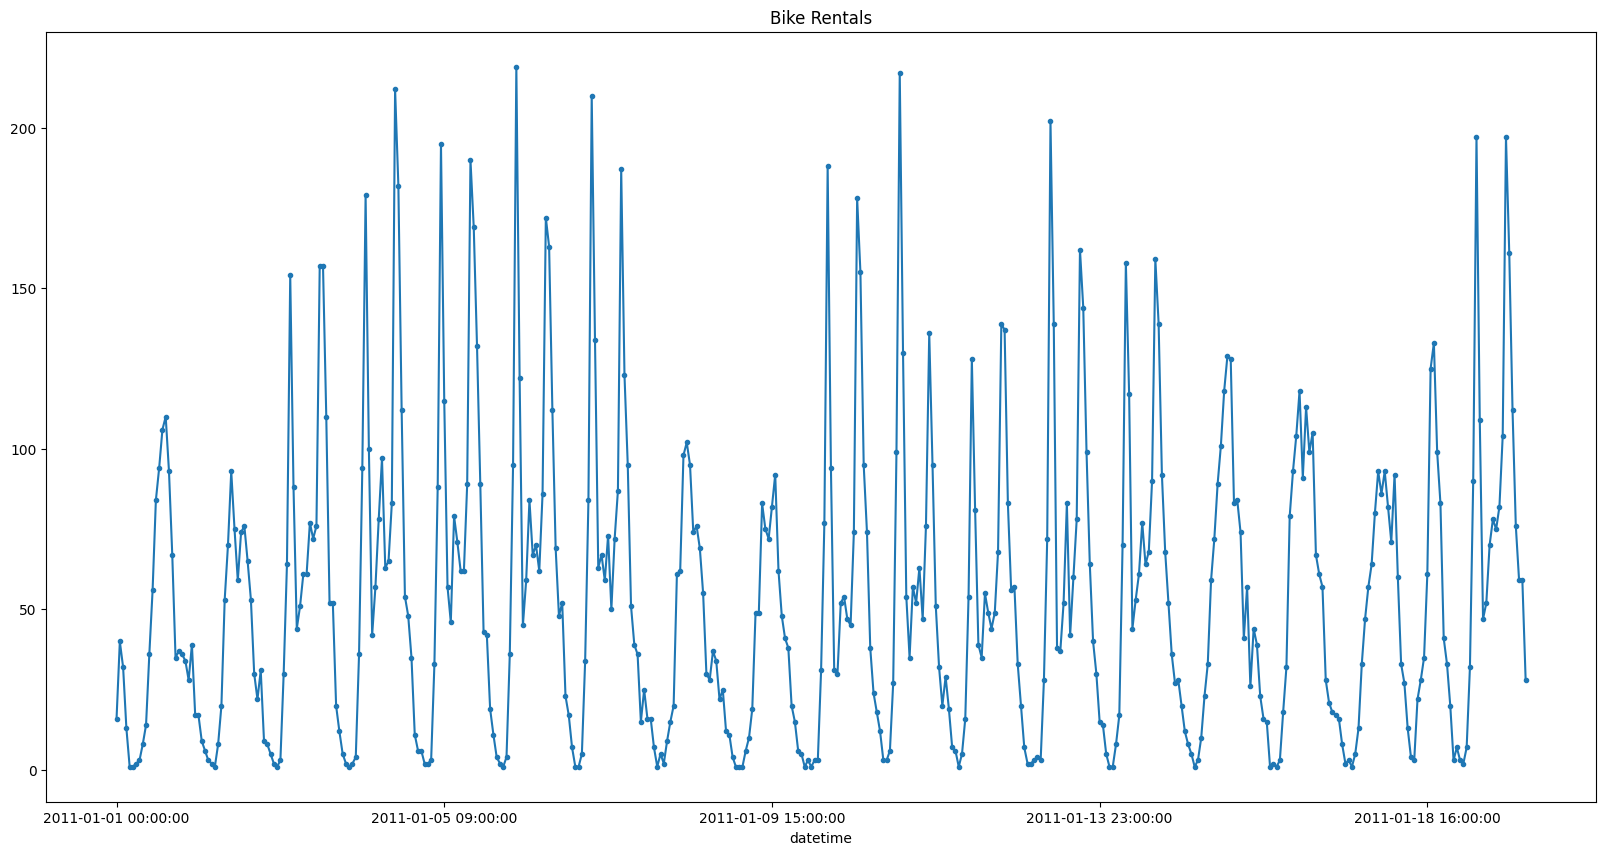

In [16]:
train[train["datetime"].str.contains("2011-01")][["datetime", "count"]].plot(x="datetime", y="count", figsize=(20, 10), title="Bike Rentals", legend=False, style=".-")

<Axes: title={'center': 'Bike Rentals'}, xlabel='datetime'>

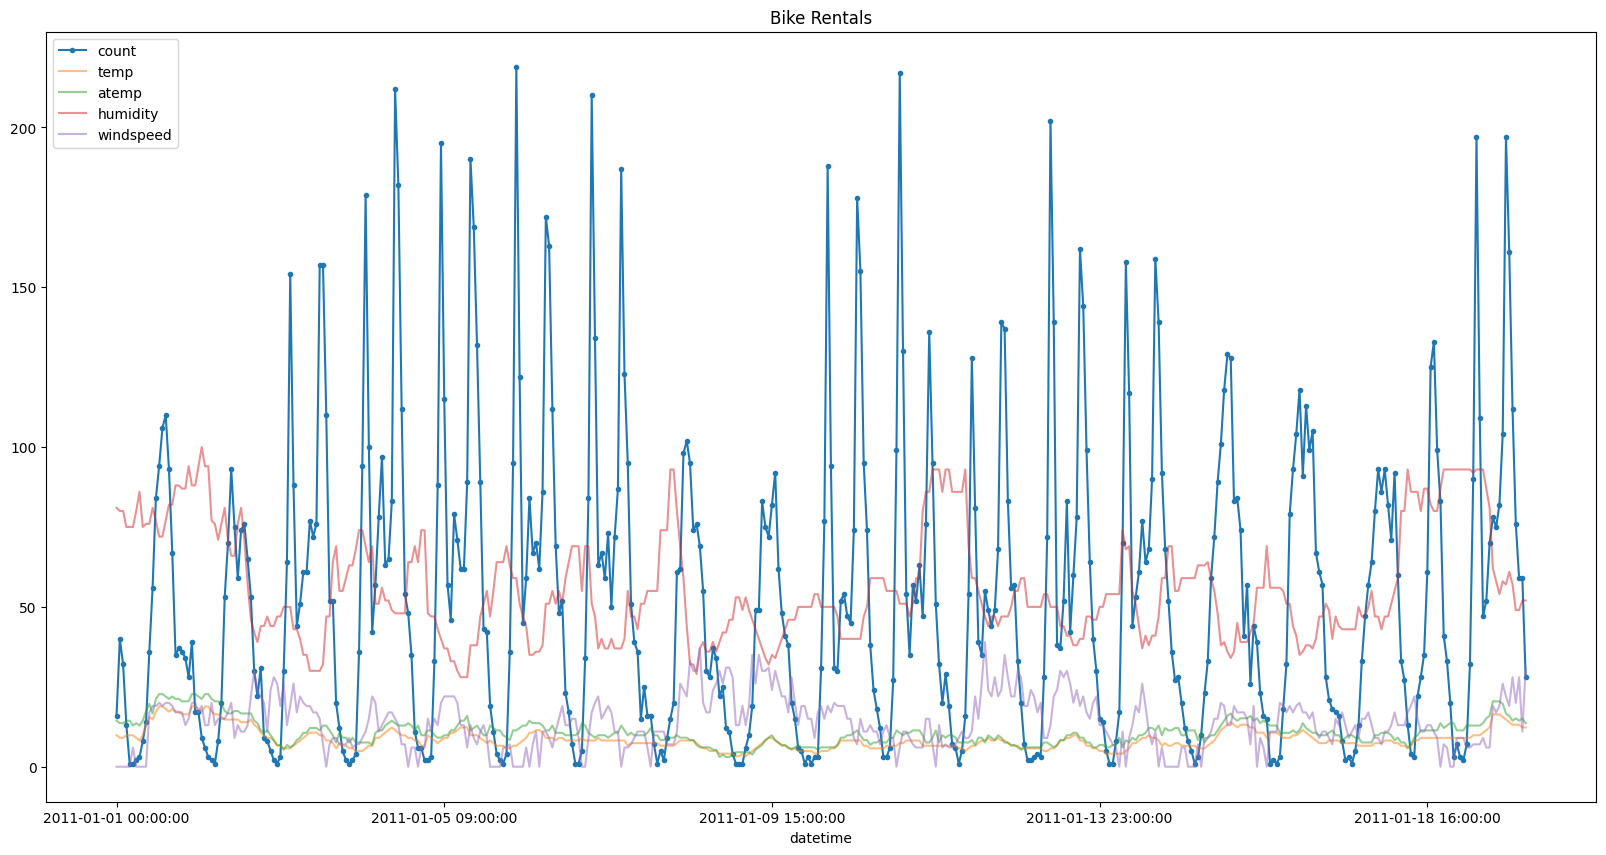

In [17]:
# Plot count, temp, atemp, humidity, windspeed where datetime contains 2011-01 and transparency for each feature except count
plot_data = train[train["datetime"].str.contains("2011-01")][["datetime", "count", "temp", "atemp", "humidity", "windspeed"]]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plot_data.plot(x="datetime", y="count", figsize=(20, 10), title="Bike Rentals", legend=True, style=".-", ax=ax)
plot_data.plot(x="datetime", y=["temp", "atemp", "humidity", "windspeed"], alpha=0.5, ax=ax)

<Axes: title={'center': 'Bike Rentals'}, xlabel='datetime'>

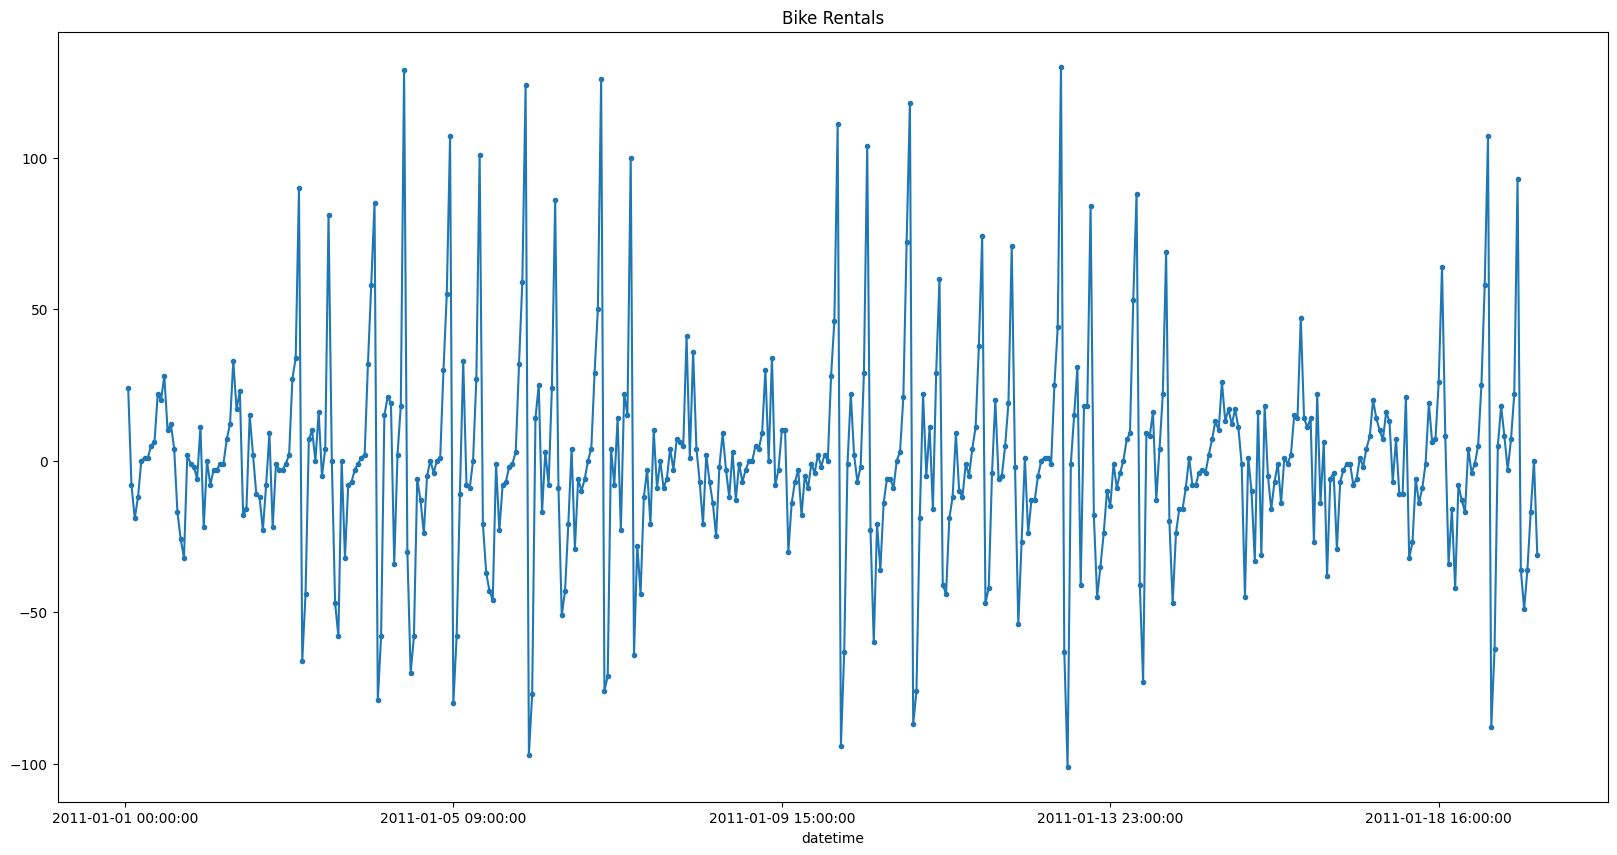

In [18]:
y_lag1 = train.copy()
y_lag1["diff"] = train["count"].diff()
y_lag1[y_lag1["datetime"].str.contains("2011-01")][["datetime", "diff"]].plot(x="datetime", y="diff", figsize=(20, 10), title="Bike Rentals", legend=False, style=".-")

In [31]:
train["datetime"] = pd.to_datetime(train["datetime"])
test["datetime"] = pd.to_datetime(test["datetime"])

# Deterministic Process

In [20]:
train["hour"] = train["datetime"].dt.hour

In [21]:
average_by_hour = train.groupby("hour")["count"].mean()

<Axes: title={'center': 'Average Bike Rentals by Hour'}, xlabel='hour'>

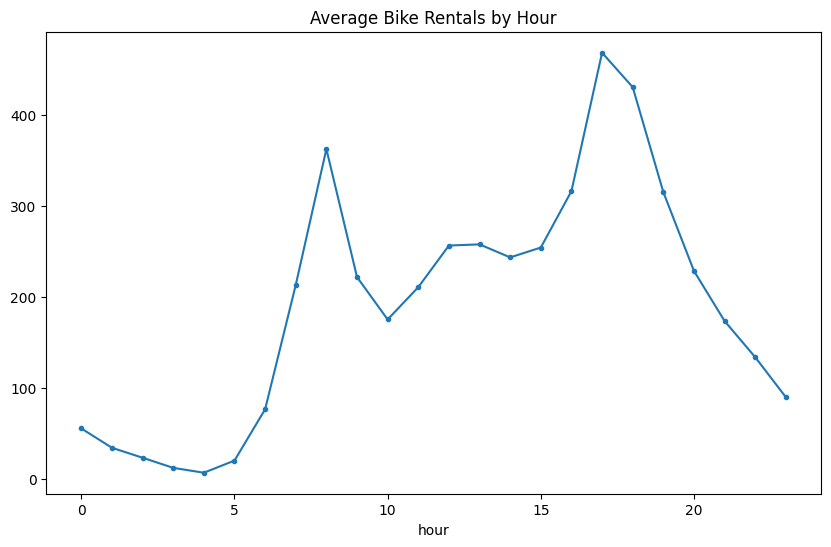

In [22]:
average_by_hour.plot(x="hour", y="count", figsize=(10, 6), title="Average Bike Rentals by Hour", legend=False, style=".-")

In [23]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

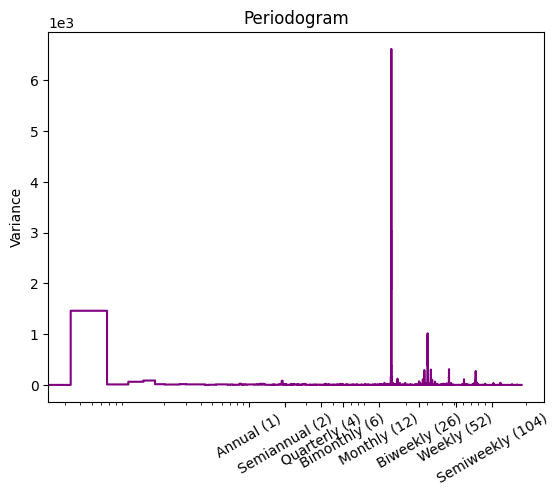

In [24]:
plot_periodogram(train["count"], ax=plt.gca())

In [25]:
y = train.copy()
y["datetime"] = y["datetime"].dt.to_period("H")
y = y.set_index("datetime")
y = y["count"]

C:\Users\ivan.trujillo_blueta\AppData\Local\Temp\ipykernel_30148\3668002019.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y["datetime"] = y["datetime"].dt.to_period("H")


In [26]:
months_numbers =  train["datetime"].dt.month.value_counts().index.shape[0] * train["datetime"].dt.year.value_counts().index.shape[0]   # 12 * 2
months_numbers

24

In [82]:
y_pred_dp = None
y_pred_test_dp = None
for i in range(1, months_numbers + 1):
    year = 2011 + (i - 1) // 12
    month = (i - 1) % 12 + 1
    print(f"Model {i} - Year {year} - Month {month}")
    fourier = CalendarFourier(freq="H", order=6)
    y_i = y[(y.index.year == year) & (y.index.month == month)]
    dp = DeterministicProcess(
        index=y_i.index,
        constant=True,
        order=2,
        seasonal=True,
        additional_terms=[fourier],
        drop=True,
    )
    X = dp.in_sample()
    X = X.reset_index()
    X["datetime"] = X["datetime"].dt.to_timestamp()
    X = X.merge(train[['datetime', 'workingday', 'holiday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 'season_3', 'season_4', 'weather_2', 'weather_3', 'weather_4']], on='datetime', how='left')
    X["datetime"] = X["datetime"].dt.to_period("h")
    X = X.set_index('datetime')

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y_i)

    # Train prediction
    if y_pred_dp is None:
        y_pred_dp = pd.DataFrame(model.predict(X), index=y_i.index, columns=["count"])
    else:
        y_pred_dp = pd.concat([y_pred_dp, pd.DataFrame(model.predict(X), index=y_i.index, columns=["count"])])
    y_pred_dp = y_pred_dp.clip(lower=0)

    # Test prediction
    X_test = dp.out_of_sample(steps=24 * 12)
    X_test = X_test.reset_index()
    X_test["datetime"] = X_test["index"].dt.to_timestamp()
    X_test = X_test.drop("index", axis=1)
    X_test = X_test.merge(test[['datetime', 'workingday', 'holiday', 'temp', 'atemp', 'humidity', 'windspeed', 'season_2', 'season_3', 'season_4', 'weather_2', 'weather_3', 'weather_4']], on='datetime', how='inner')
    X_test["datetime"] = X_test["datetime"].dt.to_period("h")
    X_test = X_test.set_index('datetime')

    if y_pred_test_dp is None:
        y_pred_test_dp = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=["count"])
    else:
        y_pred_test_dp = pd.concat([y_pred_test_dp, pd.DataFrame(model.predict(X_test), index=X_test.index, columns=["count"])])
    y_pred_test_dp = y_pred_test_dp.clip(lower=0)

    print(f"Model {i} done")
    print(f"RMSLE: {root_mean_squared_log_error(y_i, y_pred_dp.loc[y_i.index, "count"])}")

Model 1 - Year 2011 - Month 1
Model 1 done
RMSLE: 1.1345270459361647
Model 2 - Year 2011 - Month 2
Model 2 done
RMSLE: 1.1552427019548488
Model 3 - Year 2011 - Month 3
Model 3 done
RMSLE: 1.2828475089681786
Model 4 - Year 2011 - Month 4
Model 4 done
RMSLE: 0.9724619541455947
Model 5 - Year 2011 - Month 5
Model 5 done
RMSLE: 0.7891646241282987
Model 6 - Year 2011 - Month 6
Model 6 done
RMSLE: 0.715901792368265
Model 7 - Year 2011 - Month 7
Model 7 done
RMSLE: 0.728972663930004
Model 8 - Year 2011 - Month 8
Model 8 done
RMSLE: 0.7881843175475568
Model 9 - Year 2011 - Month 9
Model 9 done
RMSLE: 1.0490134559140112
Model 10 - Year 2011 - Month 10
Model 10 done
RMSLE: 0.8277928011373133
Model 11 - Year 2011 - Month 11
Model 11 done
RMSLE: 0.8441722248911261
Model 12 - Year 2011 - Month 12
Model 12 done
RMSLE: 0.9298746169816087
Model 13 - Year 2012 - Month 1
Model 13 done
RMSLE: 1.0741029941352456
Model 14 - Year 2012 - Month 2
Model 14 done
RMSLE: 1.0703834519727595
Model 15 - Year 2012 - 

In [54]:
y.index

PeriodIndex(['2011-01-01 00:00', '2011-01-01 01:00', '2011-01-01 02:00',
             '2011-01-01 03:00', '2011-01-01 04:00', '2011-01-01 05:00',
             '2011-01-01 06:00', '2011-01-01 07:00', '2011-01-01 08:00',
             '2011-01-01 09:00',
             ...
             '2012-12-19 14:00', '2012-12-19 15:00', '2012-12-19 16:00',
             '2012-12-19 17:00', '2012-12-19 18:00', '2012-12-19 19:00',
             '2012-12-19 20:00', '2012-12-19 21:00', '2012-12-19 22:00',
             '2012-12-19 23:00'],
            dtype='period[h]', name='datetime', length=10886)

<Axes: title={'center': 'Bike Rentals'}, xlabel='datetime'>

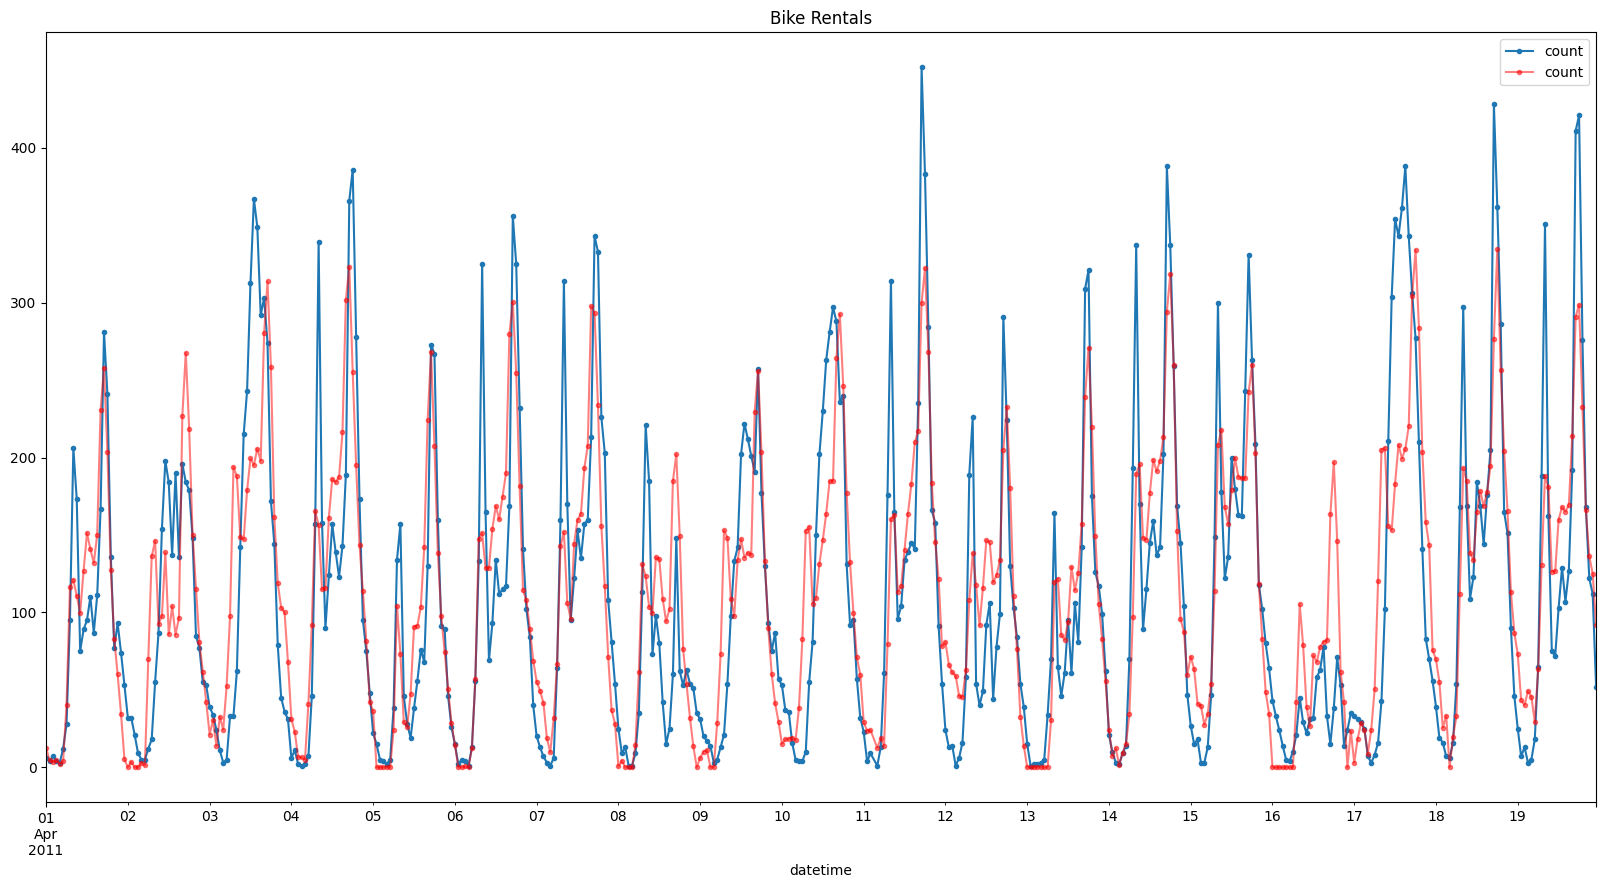

In [80]:
plot_y = y[(y.index.year == 2011) & (y.index.month == 4)]
plot_y_pred_dp = y_pred_dp[(y_pred_dp.index.year == 2011) & (y_pred_dp.index.month == 4)]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plot_y.plot(figsize=(20, 10), title="Bike Rentals", legend=True, style=".-", ax=ax)
plot_y_pred_dp.plot(figsize=(20, 10), style=".-", color="red", alpha=0.5, ax=ax)

In [83]:
root_mean_squared_log_error(y, y_pred_dp["count"])

0.9422588852719136

Order 1 sin fourier: 0.9537848662658068
Order 2 sin fourier: 0.9524046715492904
Order 3 sin fourier: 0.9542481792641088
Order 4 sin fourier: 0.9546107247085466

Order 2 con furier ME y order 2: 0.9514527267835267
Order 2 con furier ME y order 4: 0.9445609037286293
Order 2 con furier ME y order 6: 0.9422588852719136

In [50]:
y_pred_test_dp.head()

,count
datetime,
2011-01-20 00:00,75.757515
2011-01-20 01:00,94.936993
2011-01-20 02:00,118.190723
2011-01-20 03:00,108.315573
2011-01-20 04:00,106.569993


In [58]:
submission = y_pred_test_dp.reset_index()
submission["datetime"] = submission["datetime"].dt.to_timestamp()
submission.to_csv("data/submission_dp.csv", index=False)

# SARIMAX

In [84]:
for i in range(1, months_numbers + 1):
    year = 2011 + (i - 1) // 12
    month = (i - 1) % 12 + 1
    print(f"Model {i} - Year {year} - Month {month}")
    analysis_i = adfuller(y[(y.index.year == year) & (y.index.month == month)])
    print(f"ADF Statistic: {analysis_i[0]} - p-value: {analysis_i[1]}")

Model 1 - Year 2011 - Month 1
ADF Statistic: -5.7964010592597885 - p-value: 4.740848417171416e-07
Model 2 - Year 2011 - Month 2
ADF Statistic: -5.453991775580396 - p-value: 2.606322584620474e-06
Model 3 - Year 2011 - Month 3
ADF Statistic: -4.471384013744466 - p-value: 0.0002214253696310858
Model 4 - Year 2011 - Month 4
ADF Statistic: -5.635423072616718 - p-value: 1.0658252596102725e-06
Model 5 - Year 2011 - Month 5
ADF Statistic: -10.415555879712802 - p-value: 1.7582542165323066e-18
Model 6 - Year 2011 - Month 6
ADF Statistic: -10.71353265739879 - p-value: 3.2853381634737395e-19
Model 7 - Year 2011 - Month 7
ADF Statistic: -9.480370119924185 - p-value: 3.88746780146996e-16
Model 8 - Year 2011 - Month 8
ADF Statistic: -11.178954351552306 - p-value: 2.5291068830594777e-20
Model 9 - Year 2011 - Month 9
ADF Statistic: -4.7609573206886635 - p-value: 6.455262349835378e-05
Model 10 - Year 2011 - Month 10
ADF Statistic: -5.174194609656122 - p-value: 9.923704882616075e-06
Model 11 - Year 2011 

# Machine Learning

In [86]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train = train.drop("datetime", axis=1)

train.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_2,season_3,season_4,weather_2,weather_3,weather_4,hour,year,month,day
0,0,0,9.84,14.395,81,0.0,16,0,0,0,0,0,0,0,2011,1,1
1,0,0,9.02,13.635,80,0.0,40,0,0,0,0,0,0,1,2011,1,1
2,0,0,9.02,13.635,80,0.0,32,0,0,0,0,0,0,2,2011,1,1
3,0,0,9.84,14.395,75,0.0,13,0,0,0,0,0,0,3,2011,1,1
4,0,0,9.84,14.395,75,0.0,1,0,0,0,0,0,0,4,2011,1,1


In [87]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test = test.drop("datetime", axis=1)

test.head()

,holiday,workingday,temp,atemp,humidity,windspeed,season_2,season_3,season_4,weather_2,weather_3,weather_4,year,month,day,hour
0,0,1,10.66,11.365,56,26.0027,0,0,0,0,0,0,2011,1,20,0
1,0,1,10.66,13.635,56,0.0000,0,0,0,0,0,0,2011,1,20,1
2,0,1,10.66,13.635,56,0.0000,0,0,0,0,0,0,2011,1,20,2
3,0,1,10.66,12.880,56,11.0014,0,0,0,0,0,0,2011,1,20,3
4,0,1,10.66,12.880,56,11.0014,0,0,0,0,0,0,2011,1,20,4


In [88]:
y_train = train["count"]
X_train = train.drop("count", axis=1)

In [131]:
run_optimization = True

def objective(trial):

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma' : trial.suggest_float('gamma', 1e-9, 0.5),
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
        
    }
    
    params['booster'] = 'gbtree'
    params['objective'] = 'reg:squarederror'
    params["device"] = "cuda"
    params["verbosity"] = 0
    params['tree_method'] = "hist"

    xgb_model = XGBRegressor(**params)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_train).clip(min=0)
    
    return root_mean_squared_log_error(y_train, y_pred)

if run_optimization:
    
    study_name = "bike_sharing_xgb"
    xgb_study = optuna.create_study(study_name=study_name, direction="minimize")

    xgb_study.optimize(objective, n_trials=50)
    best_xgb_params = xgb_study.best_params
    best_xgb_value = xgb_study.best_value

else:
    
    best_xgb_value = 0.02183
    best_xgb_params = {
        'learning_rate': 0.7002142983587706, 
        'gamma': 0.1644060145184993, 
        'max_depth': 0, 
        'min_child_weight': 6, 
        'subsample': 0.5247125730559924, 
        'colsample_bytree': 0.6354942329996383, 
        'grow_policy': 'lossguide', 
        'n_estimators': 596, 
        'reg_lambda': 1.527225649898582e-08, 
        'reg_alpha': 0.000583555252025942
    }

print(f"best optmized accuracy: {best_xgb_value:0.5f}")
print(f"best hyperparameters: {best_xgb_params}")

best_xgb_params['booster'] = 'gbtree'
best_xgb_params['objective'] = 'reg:squarederror'
best_xgb_params['tree_method'] = "hist"
best_xgb_params["device"] = "cuda"
best_xgb_params["verbosity"] = 0

[I 2024-05-21 14:39:14,786] A new study created in memory with name: bike_sharing_xgb
[I 2024-05-21 14:39:15,613] Trial 0 finished with value: 1.103798634402268 and parameters: {'learning_rate': 0.04294659462058526, 'gamma': 0.06283933140876147, 'max_depth': 1, 'min_child_weight': 5, 'subsample': 0.5529117195661535, 'colsample_bytree': 0.9107942503117104, 'grow_policy': 'depthwise', 'n_estimators': 566, 'reg_lambda': 12.328982540640276, 'reg_alpha': 6.383479624228658e-07}. Best is trial 0 with value: 1.103798634402268.
[I 2024-05-21 14:39:32,799] Trial 1 finished with value: 0.32784929462164847 and parameters: {'learning_rate': 0.02305000868444534, 'gamma': 0.326136415346264, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.9449915710440793, 'colsample_bytree': 0.6476629166812533, 'grow_policy': 'lossguide', 'n_estimators': 676, 'reg_lambda': 2.1275454350662995, 'reg_alpha': 3.9021510347008705}. Best is trial 1 with value: 0.32784929462164847.
[I 2024-05-21 14:39:35,174] Trial 2 f

best optmized accuracy: 0.01214
best hyperparameters: {'learning_rate': 0.5492866259177901, 'gamma': 0.040478900972037976, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.48299477131935586, 'colsample_bytree': 0.45716395353122485, 'grow_policy': 'lossguide', 'n_estimators': 648, 'reg_lambda': 3.6336370130375255e-09, 'reg_alpha': 0.05880922327384553}


In [97]:
run_optimization = True

def objective(trial):
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'depth': trial.suggest_int('depth', 0, 12),
        'l2_leaf_reg' : trial.suggest_float('l2_leaf_reg', 1e-9, 0.5),
        'grow_policy': trial.suggest_categorical('grow_policy', ["Depthwise", "Lossguide", "SymmetricTree"]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01, 0.1, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1.0, log=True)
    
    params['objective'] = 'RMSE'
    params["task_type"] = "CPU"
    params["devices"] = "0"
    params["verbose"] = 0

    cb_model = CatBoostRegressor(**params)

    cb_model.fit(
        X_train,
        y_train,
        verbose=0
    )

    y_pred = cb_model.predict(X_train).clip(min=0)
    
    return root_mean_squared_log_error(y_train, y_pred)

if run_optimization:
    
    study_name = "bike_demand_cb"
    cb_study = optuna.create_study(study_name=study_name, direction="minimize")

    cb_study.optimize(objective, n_trials=100)
    best_cb_params = cb_study.best_params
    best_cb_value = cb_study.best_value

else:
    
    best_cb_value = 0.50822
    best_cb_params = {
        'iterations': 800, 
        'learning_rate': 0.16733382068701116, 
        'depth': 11, 
        'l2_leaf_reg': 0.26292912066943436, 
        'grow_policy': "Depthwise", 
        'min_child_samples': 1, 
        'colsample_bylevel': 0.08518228685098327, 
        'bootstrap_type': "MVS",
        # 'subsample': 0.36986612821028797,
    }

print(f"best optmized accuracy: {best_cb_value:0.5f}")
print(f"best hyperparameters: {best_cb_params}")

best_cb_params['objective'] = 'RMSE'
best_cb_params["task_type"] = "CPU"
best_cb_params["devices"] = "0"

[I 2024-05-21 14:17:16,727] A new study created in memory with name: bike_demand_cb
[I 2024-05-21 14:17:16,896] Trial 0 finished with value: 1.5685029070583356 and parameters: {'iterations': 101, 'learning_rate': 0.016123874927820817, 'depth': 1, 'l2_leaf_reg': 0.3060856636649901, 'grow_policy': 'SymmetricTree', 'min_child_samples': 8, 'colsample_bylevel': 0.010321432547019786, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.9879878868118228}. Best is trial 0 with value: 1.5685029070583356.
[I 2024-05-21 14:17:17,603] Trial 1 finished with value: 1.0670768161588866 and parameters: {'iterations': 532, 'learning_rate': 0.1272771538218104, 'depth': 6, 'l2_leaf_reg': 0.34668179789065695, 'grow_policy': 'SymmetricTree', 'min_child_samples': 1, 'colsample_bylevel': 0.028814858538107252, 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 1.0670768161588866.
[I 2024-05-21 14:17:18,161] Trial 2 finished with value: 1.0392671715716126 and parameters: {'iterations': 376, 'learning_rate'

best optmized accuracy: 0.50822
best hyperparameters: {'iterations': 800, 'learning_rate': 0.16733382068701116, 'depth': 11, 'l2_leaf_reg': 0.26292912066943436, 'grow_policy': 'Depthwise', 'min_child_samples': 1, 'colsample_bylevel': 0.08518228685098327, 'bootstrap_type': 'MVS'}


In [95]:
run_optimization = True

def objective(trial):
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    lgb_model = LGBMRegressor(**params)

    lgb_model = lgb_model.fit(X_train, y_train)

    y_pred = lgb_model.predict(X_train).clip(min=0)

    return root_mean_squared_log_error(y_train, y_pred)

if run_optimization:
    
    study_name = "bike_demand_lgb"
    lgb_study = optuna.create_study(study_name=study_name, direction="minimize")

    lgb_study.optimize(objective, n_trials=50)
    best_lgb_params = lgb_study.best_params
    best_lgb_value = lgb_study.best_value

else:
    
    best_lgb_value = 0.26374
    best_lgb_params = {
        'objective': "regression",
        'metric': "rmse",
        'verbosity': -1,
        "boosting_type": "gbdt",
        'lambda_l1': 2.8567392847322855e-05,
        'lambda_l2': 0.005850223619061941, 
        'num_leaves': 243, 
        'feature_fraction': 0.9581862917667306, 
        'bagging_fraction': 0.9999033234271043, 
        'bagging_freq': 4, 
        'min_child_samples': 8,
    }

print(f"best optmized accuracy: {best_lgb_value:0.5f}")
print(f"best hyperparameters: {best_lgb_params}")

[I 2024-05-21 14:15:02,125] A new study created in memory with name: bike_demand_lgb
[I 2024-05-21 14:15:02,741] Trial 0 finished with value: 0.3566860820695208 and parameters: {'lambda_l1': 1.3400901543965242e-08, 'lambda_l2': 0.004334485049390958, 'num_leaves': 208, 'feature_fraction': 0.9579642219112058, 'bagging_fraction': 0.6577768319533344, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 0 with value: 0.3566860820695208.
[I 2024-05-21 14:15:02,922] Trial 1 finished with value: 0.49745449456083474 and parameters: {'lambda_l1': 0.0015575865526840777, 'lambda_l2': 0.041042448434331226, 'num_leaves': 120, 'feature_fraction': 0.46741390990606396, 'bagging_fraction': 0.9334064630107538, 'bagging_freq': 6, 'min_child_samples': 55}. Best is trial 0 with value: 0.3566860820695208.
[I 2024-05-21 14:15:03,100] Trial 2 finished with value: 0.4918736061717829 and parameters: {'lambda_l1': 0.00010988733696156611, 'lambda_l2': 6.426861298704098e-08, 'num_leaves': 115, 'feature_fracti

best optmized accuracy: 0.26374
best hyperparameters: {'lambda_l1': 2.8567392847322855e-05, 'lambda_l2': 0.005850223619061941, 'num_leaves': 243, 'feature_fraction': 0.9581862917667306, 'bagging_fraction': 0.9999033234271043, 'bagging_freq': 4, 'min_child_samples': 8}


In [98]:
stacking_model = StackingRegressor(
    estimators=[('xgb', XGBRegressor(**best_xgb_params)), ('cb', CatBoostRegressor(**best_cb_params)), ('lgb', LGBMRegressor(**best_lgb_params))],
    final_estimator=LinearRegression()
)

In [99]:
stacking_model.fit(X_train, y_train)

0:	learn: 166.5862079	total: 2.73ms	remaining: 2.18s
1:	learn: 166.5862079	total: 4.22ms	remaining: 1.69s
2:	learn: 164.3720196	total: 5.63ms	remaining: 1.5s
3:	learn: 164.3720196	total: 6.72ms	remaining: 1.34s
4:	learn: 155.0342636	total: 9.84ms	remaining: 1.56s
5:	learn: 155.0342636	total: 10.9ms	remaining: 1.45s
6:	learn: 151.6795582	total: 12.9ms	remaining: 1.46s
7:	learn: 151.6795581	total: 14ms	remaining: 1.39s
8:	learn: 151.6795581	total: 15.3ms	remaining: 1.34s
9:	learn: 151.4514625	total: 16.8ms	remaining: 1.33s
10:	learn: 145.1320593	total: 19.4ms	remaining: 1.39s
11:	learn: 140.2735387	total: 21ms	remaining: 1.38s
12:	learn: 137.6444696	total: 23.7ms	remaining: 1.43s
13:	learn: 137.6444696	total: 24.9ms	remaining: 1.4s
14:	learn: 135.6142312	total: 26.9ms	remaining: 1.41s
15:	learn: 135.5230668	total: 28.3ms	remaining: 1.39s
16:	learn: 134.0361521	total: 31.4ms	remaining: 1.45s
17:	learn: 133.6263966	total: 32.8ms	remaining: 1.43s
18:	learn: 130.5757135	total: 38.7ms	remaini

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6354942329996383,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.1644060145184993,
                                            grow_policy='lossguide',
                                            importance_type=None...
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('cb',
                               <catboost.core.CatBoostRegressor object at 0x000001E3539DB920>),
                              ('lgb',
                               LGBMRegressor(bagging_fraction=0.9999033234271043,
                                             bagging_freq=4,
                                             feature_fraction=0.9581862917667306,
                                             lambda_l1=2.8567392847322855e-05,
                                             lambda_l2=0.005850223619061941,
                                             min_child_samples=8,
                                             num_leaves=243))],
                  final_estimator=LinearRegression())

In [100]:
y_pred_ml = stacking_model.predict(X_train).clip(min=0)

[LightGBM] [Warning] feature_fraction is set=0.9581862917667306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9581862917667306
[LightGBM] [Warning] lambda_l1 is set=2.8567392847322855e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8567392847322855e-05
[LightGBM] [Warning] lambda_l2 is set=0.005850223619061941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005850223619061941
[LightGBM] [Warning] bagging_fraction is set=0.9999033234271043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999033234271043
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [101]:
root_mean_squared_log_error(y_train, y_pred_ml)

0.906803450073773

In [102]:
xgb_model = XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train, y_train)
y_pred_ml_xgb = xgb_model.predict(X_train).clip(min=0)
root_mean_squared_log_error(y_train, y_pred_ml_xgb)

0.021830217633488618

In [103]:
lgb_model = LGBMRegressor(**best_lgb_params)
lgb_model.fit(X_train, y_train)
y_pred_ml_lgb = lgb_model.predict(X_train).clip(min=0)
root_mean_squared_log_error(y_train, y_pred_ml_lgb)

[LightGBM] [Warning] feature_fraction is set=0.9581862917667306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9581862917667306
[LightGBM] [Warning] lambda_l1 is set=2.8567392847322855e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8567392847322855e-05
[LightGBM] [Warning] lambda_l2 is set=0.005850223619061941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005850223619061941
[LightGBM] [Warning] bagging_fraction is set=0.9999033234271043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999033234271043
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9581862917667306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9581862917667306
[LightGBM] [Warning] lambda_l1 is set=2.8567392847322855e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8567392847322855e-05
[LightGBM] [Warni

0.2637424335307731

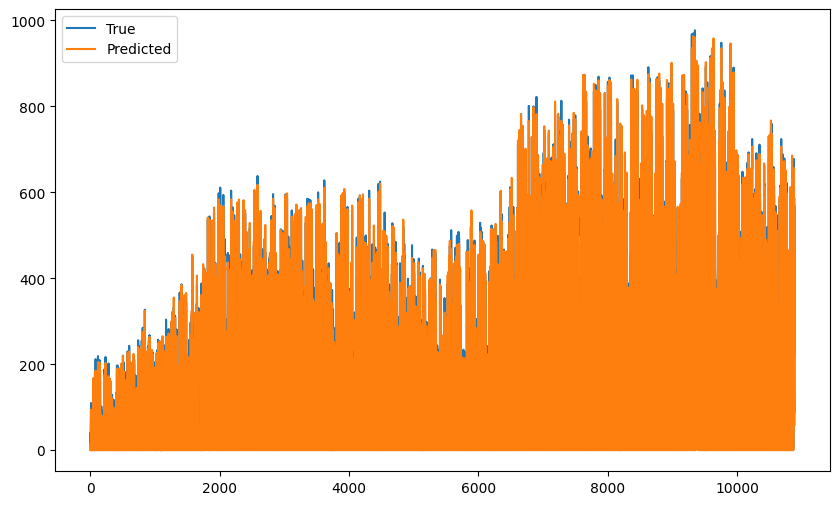

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(y_train, label="True")
plt.plot(y_pred_ml, label="Predicted")
plt.legend()

<Axes: title={'center': 'Bike Rentals'}, xlabel='datetime'>

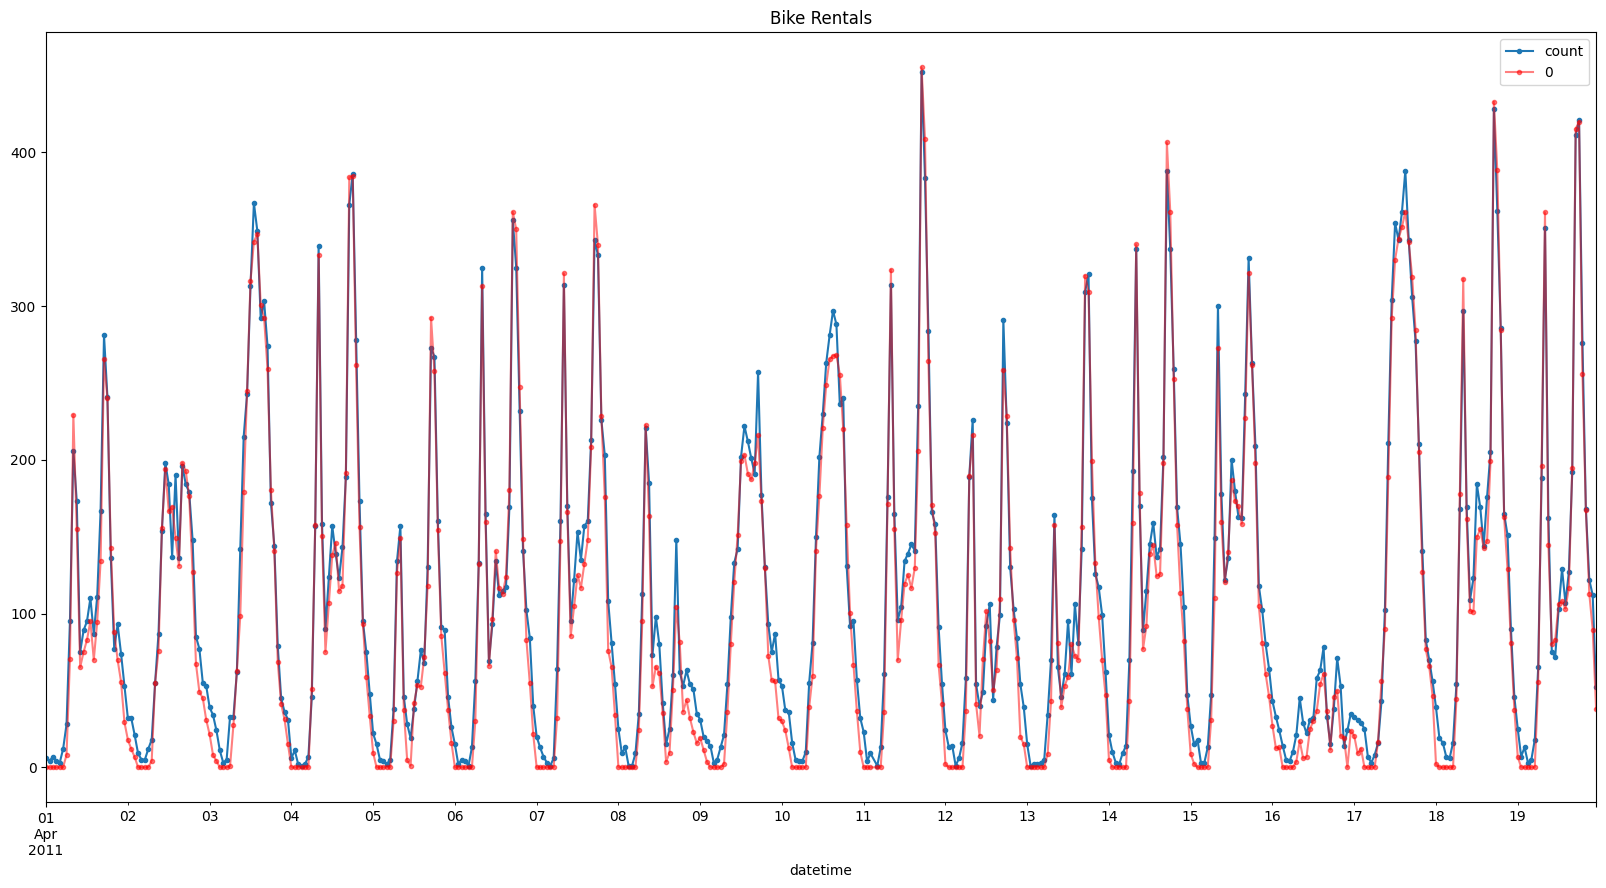

In [105]:
plot_y = y[(y.index.year == 2011) & (y.index.month == 4)]
plot_y_pred_ml = pd.DataFrame(y_pred_ml, index=y.index)
plot_y_pred_ml = plot_y_pred_ml[(plot_y_pred_ml.index.year == 2011) & (plot_y_pred_ml.index.month == 4)]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plot_y.plot(figsize=(20, 10), title="Bike Rentals", legend=True, style=".-", ax=ax)
plot_y_pred_ml.plot(figsize=(20, 10), style=".-", color="red", alpha=0.5, ax=ax)

<Axes: title={'center': 'Bike Rentals'}, xlabel='datetime'>

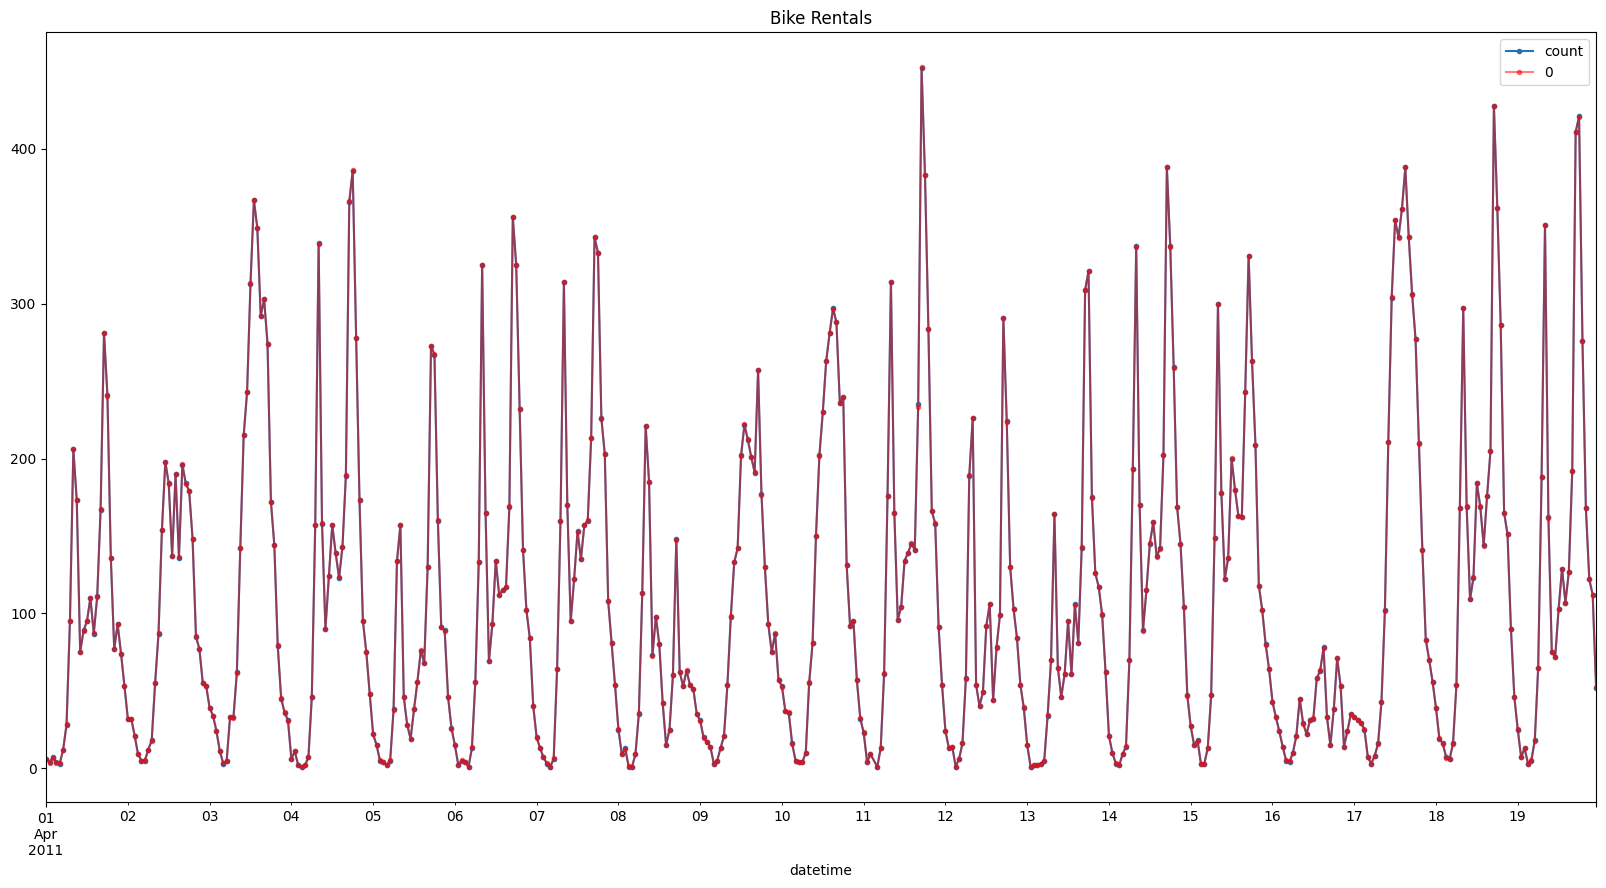

In [106]:
plot_y = y[(y.index.year == 2011) & (y.index.month == 4)]
plot_y_pred_ml_xgb = pd.DataFrame(y_pred_ml_xgb, index=y.index)
plot_y_pred_ml_xgb = plot_y_pred_ml_xgb[(plot_y_pred_ml_xgb.index.year == 2011) & (plot_y_pred_ml_xgb.index.month == 4)]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plot_y.plot(figsize=(20, 10), title="Bike Rentals", legend=True, style=".-", ax=ax)
plot_y_pred_ml_xgb.plot(figsize=(20, 10), style=".-", color="red", alpha=0.5, ax=ax)

<Axes: title={'center': 'Bike Rentals'}, xlabel='datetime'>

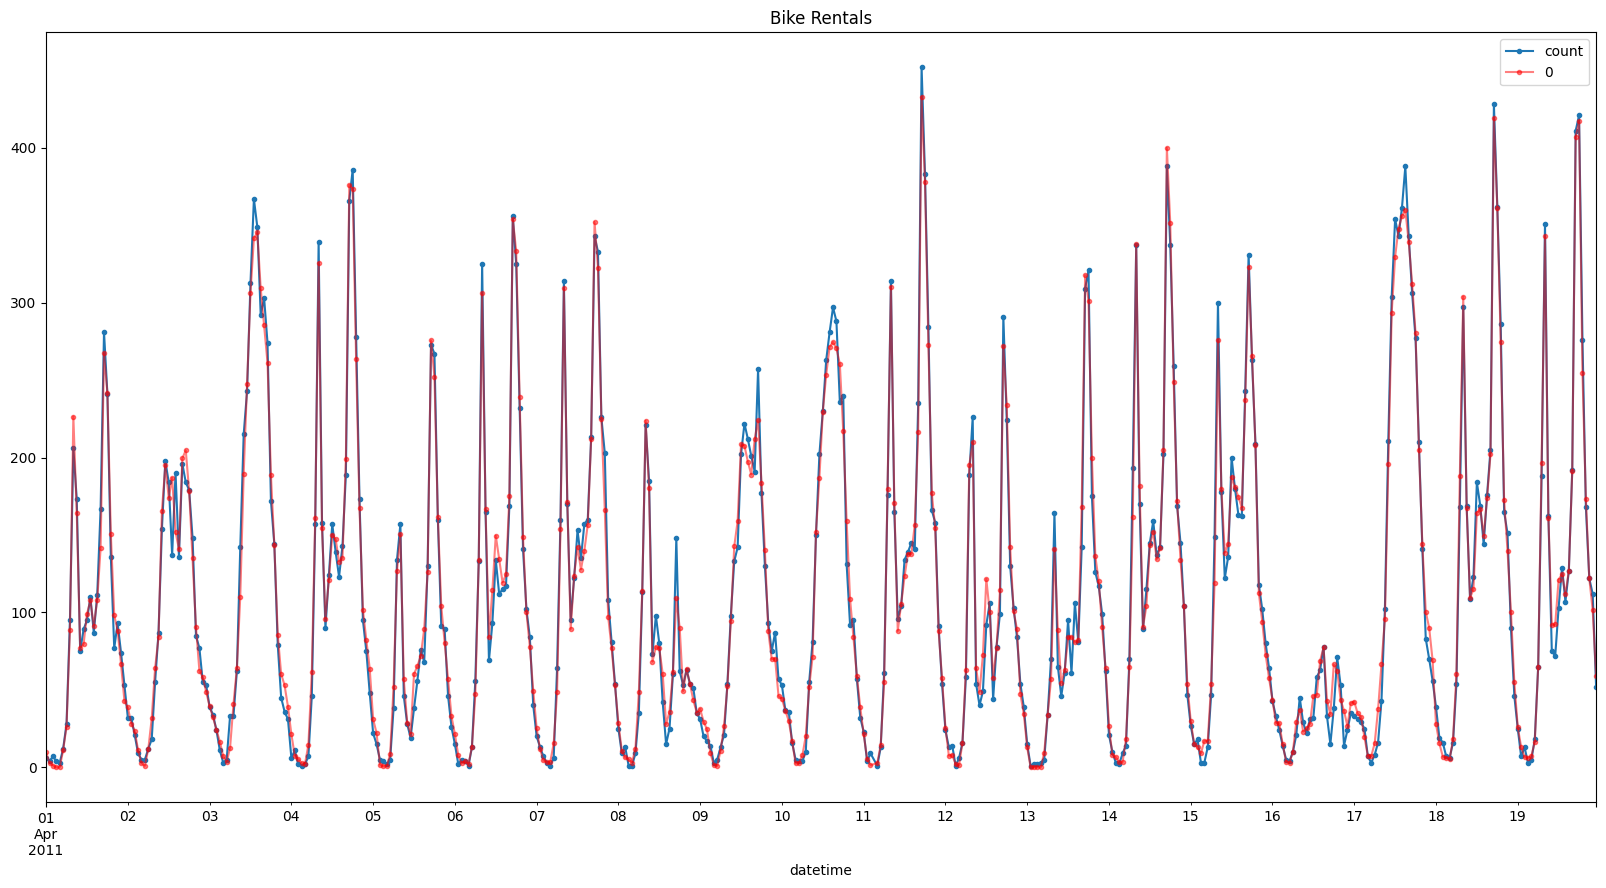

In [107]:
plot_y = y[(y.index.year == 2011) & (y.index.month == 4)]
plot_y_pred_ml_lgb = pd.DataFrame(y_pred_ml_lgb, index=y.index)
plot_y_pred_ml_lgb = plot_y_pred_ml_lgb[(plot_y_pred_ml_lgb.index.year == 2011) & (plot_y_pred_ml_lgb.index.month == 4)]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plot_y.plot(figsize=(20, 10), title="Bike Rentals", legend=True, style=".-", ax=ax)
plot_y_pred_ml_lgb.plot(figsize=(20, 10), style=".-", color="red", alpha=0.5, ax=ax)

In [127]:
test = test[X_train.columns]
y_pred_test_ml = stacking_model.predict(test)
test["datetime"] = test["year"].astype(str) + "-" + test["month"].astype(str) + "-" + test["day"].astype(str) + " " + test["hour"].astype(str) + ":00:00"
test["datime"] = pd.to_datetime(test["datetime"])
test["datetime"] = test["datime"].dt.strftime('%Y-%m-%d %H:%M:%S')
y_pred_test_ml = pd.concat([test["datetime"], pd.DataFrame(y_pred_test_ml.clip(0.0), columns=["count"])], axis=1)
y_pred_test_ml.to_csv("data/submission_stack_ml.csv", index=False)

[LightGBM] [Warning] feature_fraction is set=0.9581862917667306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9581862917667306
[LightGBM] [Warning] lambda_l1 is set=2.8567392847322855e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8567392847322855e-05
[LightGBM] [Warning] lambda_l2 is set=0.005850223619061941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005850223619061941
[LightGBM] [Warning] bagging_fraction is set=0.9999033234271043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999033234271043
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [129]:
test = test[X_train.columns]
y_pred_test_ml_xgb = xgb_model.predict(test)
test["datetime"] = test["year"].astype(str) + "-" + test["month"].astype(str) + "-" + test["day"].astype(str) + " " + test["hour"].astype(str) + ":00:00"
test["datime"] = pd.to_datetime(test["datetime"])
test["datetime"] = test["datime"].dt.strftime('%Y-%m-%d %H:%M:%S')
y_pred_test_ml_xgb = pd.concat([test["datetime"], pd.DataFrame(y_pred_test_ml_xgb.clip(0.0), columns=["count"])], axis=1)
y_pred_test_ml_xgb.to_csv("data/submission_xgb_ml.csv", index=False)

In [130]:
test = test[X_train.columns]
y_pred_test_ml_lgb = lgb_model.predict(test)
test["datetime"] = test["year"].astype(str) + "-" + test["month"].astype(str) + "-" + test["day"].astype(str) + " " + test["hour"].astype(str) + ":00:00"
test["datime"] = pd.to_datetime(test["datetime"])
test["datetime"] = test["datime"].dt.strftime('%Y-%m-%d %H:%M:%S')
y_pred_test_ml_lgb = pd.concat([test["datetime"], pd.DataFrame(y_pred_test_ml_lgb.clip(0.0), columns=["count"])], axis=1)
y_pred_test_ml_lgb.to_csv("data/submission_lgb_ml.csv", index=False)

[LightGBM] [Warning] feature_fraction is set=0.9581862917667306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9581862917667306
[LightGBM] [Warning] lambda_l1 is set=2.8567392847322855e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8567392847322855e-05
[LightGBM] [Warning] lambda_l2 is set=0.005850223619061941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005850223619061941
[LightGBM] [Warning] bagging_fraction is set=0.9999033234271043, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999033234271043
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
